# Imports and Defaults

In [2]:
from collections import defaultdict
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import scipy.stats as stats

# add to path in jupyter notebook
sys.path.append("/mnt/home/gturok/drghmc/src/utils")
from posteriors_new import get_true_params, get_true_params_squared

In [3]:
sns.set_theme(style="darkgrid")
posterior_name = "funnel10"
posterior_dir = os.path.join("..", "..", "posteriors")
data_dir = os.path.join("..", "..", "data", posterior_name)


%load_ext autoreload

# Load Data

In [4]:
summary = pl.read_parquet(os.path.join(data_dir, "summary.parquet"))
summary.describe()

statistic,chain,damping,max_proposals,metric,probabilistic,reduction_factor,sampler_type,step_count_method,step_size,step_size_factor,hparams,num_nans,max_se1,max_se2,p0_se1,p1_se1,p2_se1,p3_se1,p4_se1,p5_se1,p6_se1,p7_se1,p8_se1,p9_se1,p0_se2,p1_se2,p2_se2,p3_se2,p4_se2,p5_se2,p6_se2,p7_se2,p8_se2,p9_se2,step_count,step_count_factor
str,f64,f64,f64,f64,f64,f64,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4405.0,4400.0,4400.0,4400.0,4400.0,4400.0,"""4405""","""4000""",0.0,4400.0,"""4405""",4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,4405.0,0.0,400.0
"""null_count""",0.0,5.0,5.0,5.0,5.0,5.0,"""0""","""405""",4405.0,5.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4405.0,4005.0
"""mean""",2.0,0.265455,3.5,1.0,0.0,7.5,null,null,null,3.3,null,3.7592e7,7.635495,500592.927888,0.8186,1.212679,4.273447,3.522798,0.995649,0.999372,1.134992,1.894176,2.183241,5.270488,15.672466,50478.534945,180589.853603,244501.754969,47085.170651,55906.439687,36900.317117,89425.727235,98213.218906,427794.841883,null,0.9
"""std""",1.414374,0.290811,1.118161,0.0,null,5.362512,null,null,null,2.821668,null,2.2788e8,238.104835,2.2733e7,3.786864,23.705812,202.916272,132.475016,14.574173,27.918949,35.526589,64.040809,62.398871,233.043133,140.80181,1.5960e6,7.9224e6,1.0718e7,1.5446e6,2.1826e6,1.1743e6,4.6932e6,3.6767e6,2.1759e7,null,0.0
"""min""",0.0,0.01,2.0,1.0,0.0,2.0,"""drghmc""","""const_step_cou…",null,0.5,"""damping=0.01__…",0.0,0.008626,657.352949,1.0737e-8,3.1117e-10,3.6385e-10,1.5907e-8,2.1731e-9,2.4738e-9,3.3318e-9,1.3619e-13,7.3660e-11,6.3810e-10,4.6780e-7,0.05311,0.001128,0.015753,0.000114,0.019178,0.001389,0.009555,0.00167,0.164942,null,0.9
"""25%""",1.0,0.05,3.0,1.0,null,4.0,null,null,null,1.0,null,0.0,0.118217,6152.419332,0.015954,0.003052,0.004537,0.004778,0.003571,0.003397,0.003836,0.003248,0.003786,0.005072,0.60869,2215.552114,3163.650654,2179.371173,2424.042337,2697.949156,1678.59147,1879.494617,3545.852294,5782.851454,null,0.9
"""50%""",2.0,0.1,4.0,1.0,null,8.0,null,null,null,2.0,null,0.0,0.267004,7960.521565,0.074054,0.019896,0.02597,0.031057,0.021644,0.019958,0.022435,0.017359,0.021224,0.029593,2.241711,3463.102847,4733.005016,3444.387183,3719.115977,4086.503437,2769.913836,3007.977455,5119.953783,7775.538563,null,0.9
"""75%""",3.0,0.5,4.0,1.0,null,8.0,null,null,null,5.0,null,0.0,0.820601,9338.017748,0.242269,0.093202,0.095382,0.142627,0.083586,0.078885,0.090421,0.08403,0.089133,0.108441,6.272388,4371.021976,5824.459017,4410.553605,4695.904149,5156.207261,3678.760114,3892.501688,6271.703371,9132.736529,null,0.9
"""max""",4.0,1.0,5.0,1.0,0.0,16.0,"""nuts""","""const_traj_len…",null,8.0,"""sampler_type=n…",5.8143e9,14904.869886,1.4069e9,90.782996,1055.416498,13024.938125,7294.765753,498.794175,1727.926927,2228.841747,3953.501377,2884.438543,14904.869886,7230.685296,8.6146e7,3.9280e8,5.3864e8,8.7763e7,1.1742e8,5.4094e7,3.0873e8,1.9567e8,1.4069e9,null,0.9


# Squared Error Across Chains

WLOG consider a model parameter with true value $\theta$ and an estimate $\hat{\theta} = \frac{1}{n} \sum_{i=1}^n \theta_i$, with $\theta_i$ s drawn from our sampler. The squared error of our estimate is then:

$$ \text{SE} = (\hat{\theta} - \theta)^2 $$

We compute the squared error across different gradient evaluations to see how the squared error changes as we generate more draws:

$$ \text{SE}_i = (\hat{\theta}_i - \theta)^2 $$

where $\hat{\theta}_i = \frac{1}{i} \sum_{j=1}^i \theta_j$

To compute squared error *across* chains we cannot simply average the squared error because it is not a linear calculation. Instead we concatonate chains into one long series of draws and then compute the squared error.

For $C$ chains, construct $\hat{\theta}_i$ as follows:

$$ \hat{\theta}_i = \frac{1}{i} \sum_{j=1}^i \sum_{k=1}^C \theta_{jk} $$

where $\theta_{jk}$ is the $j$ th draw from the $k$ th chain.

In [5]:
def get_dir_name(hparams_dict, chain):
    
    if hparams_dict["sampler_type"] == "nuts":
        return f"burn_in=0__chain={chain}__gradient_budget=1000000__metric={hparams_dict['metric']}__sampler_type={hparams_dict['sampler_type']}__seed=1234"
    
    elif hparams_dict["sampler_type"] == "drghmc":
        return f"burn_in=0__chain={chain}__damping={hparams_dict['damping']}__gradient_budget=1000000__max_proposals={hparams_dict['max_proposals']}__metric={hparams_dict['metric']}__probabilistic={hparams_dict['probabilistic']}__reduction_factor={hparams_dict['reduction_factor']}__sampler_type={hparams_dict['sampler_type']}__seed=1234__step_count_method={hparams_dict['step_count_method']}__step_size={hparams_dict['step_size']}__step_size_factor={hparams_dict['step_size_factor']}"
    
    elif hparams_dict["sampler_type"] == "drhmc":
        return f"burn_in=0__chain={chain}__damping={int(hparams_dict['damping'])}__gradient_budget=1000000__max_proposals={hparams_dict['max_proposals']}__metric={hparams_dict['metric']}__probabilistic={hparams_dict['probabilistic']}__reduction_factor={hparams_dict['reduction_factor']}__sampler_type={hparams_dict['sampler_type']}__seed=1234__step_count={hparams_dict['step_count']}__step_count_factor={hparams_dict['step_count_factor']}__step_size={hparams_dict['step_size']}__step_size_factor={hparams_dict['step_size_factor']}"
    
    else:
        raise ValueError(f"Unknown sampler type: {hparams_dict['sampler_type']}")

def load_one_chain(hparam_dict, chain):
    dir_name = get_dir_name(hparam_dict, chain)
    path = os.path.join(data_dir, dir_name, "history.npz")
    history = np.load(path)
    draws = history["draws"] # [num_draws, num_params]
    grad_evals = history["grad_evals"] # [num_draws]
    return np.concatenate([grad_evals.reshape(-1, 1), draws], axis=1)

def load_chains(hparam_dict):
    draws_list = [load_one_chain(hparam_dict, chain) for chain in range(5)] # [5, num_draws, num_params + 1]
    draws = np.concatenate(draws_list, axis=0) # [5 * num_draws, num_params + 1]
    draws = draws[draws[:, 0].argsort()] # sort by grad_evals
    return draws[:, 0], draws[:, 1:] # grad_evals, params

In [21]:
# # drhmc
# hparam_dict = dict(
#     chain=4,
#     damping=1,
#     gradient_budget=1000000,
#     max_proposals=3,
#     metric=1,
#     probabilistic=False,
#     reduction_factor=8,
#     sampler_type="drhmc",
#     seed=1234,
#     step_count=None,
#     step_count_factor=0.9,
#     step_size=None,
#     step_size_factor=0.5,
# )

# nuts
hparam_dict = dict(
    chain=0,
    metric="diag_cov",
    sampler_type="nuts",
    seed=1234,
)
    
grad_evals, draws = load_chains(hparam_dict)

In [22]:
true_params = get_true_params(posterior_name, posterior_dir)
true_params_squared = get_true_params_squared(posterior_name, posterior_dir)

denom = np.arange(1, draws.shape[0] + 1).reshape(-1, 1)
est_params = np.cumsum(draws, axis=0) / denom
est_params_squared = np.cumsum(draws ** 2, axis=0) / denom

se1 = np.square(est_params - true_params)
se2 = np.square(est_params_squared - true_params_squared)
rse2 = np.square((est_params_squared - true_params_squared) / true_params_squared)

In [23]:
log_scale_se1 = se1[:, 0]
latent_se1 = np.max(se1[:, 1:], axis=1)

log_scale_se2 = se2[:, 0]
latent_se2 = np.max(se2[:, 1:], axis=1)

log_scale_rse2 = rse2[:, 0]
latent_rse2 = np.max(rse2[:, 1:], axis=1)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, '[NUTS] Squared Error vs Gradient Evaluations')

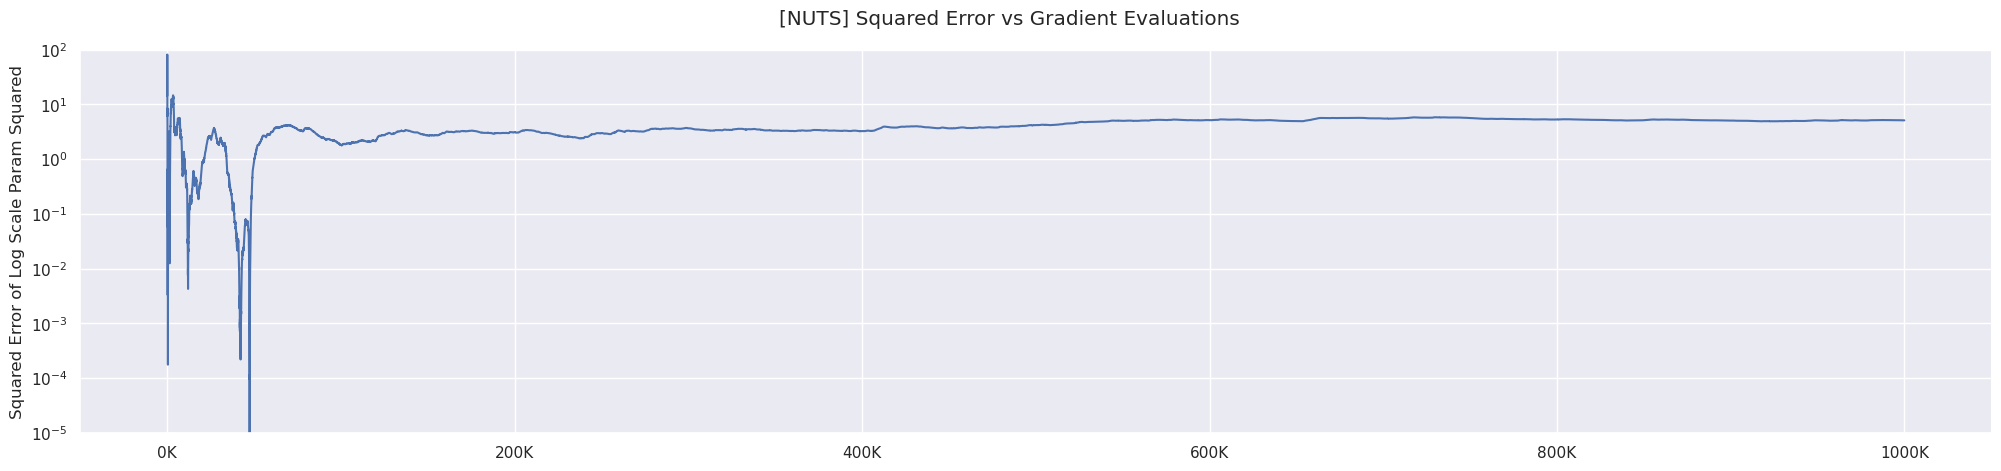

In [31]:
fig = sns.relplot(
    kind="line",
    x=grad_evals, 
    y=log_scale_se2, 
    aspect=4,
    estimator=None,
)

# set y label and x label
fig.set(ylabel="Squared Error of Log Scale Param Squared")
fig.set(yscale="log")
# fig.set(ylim=(1e-9, 1e2))
fig.set(ylim=(1e-5, 1e2))
fig.set(xticks=[0, 200000, 400000, 600000, 800000, 1000000], xticklabels=["0K", "200K", "400K", "600K", "800K", "1000K"])
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("[NUTS] Squared Error vs Gradient Evaluations")

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(-12.0, 12.0)

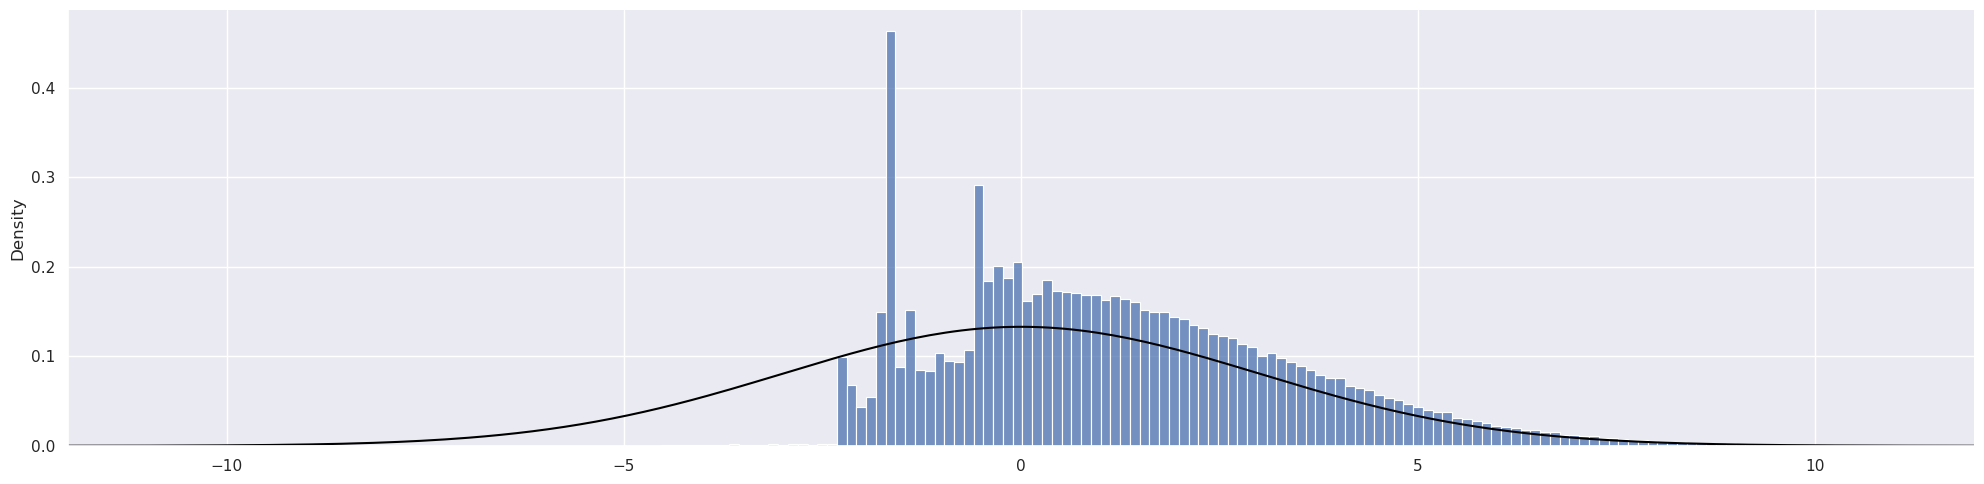

In [80]:
fig = sns.displot(
    kind="hist",
    x=draws[:, 0],
    stat="density",
    bins=150,
    aspect=4,
)

x = np.linspace(-50, 50, 1000)
y = stats.norm.pdf(x, 0, 3)
plt.plot(x, y, label="Ref Draws", color="black")

plt.xlim(-12, 12)

In [81]:
draws[:, 0].mean() ** 2

1.5254595522198426